In [2]:
from pyrosetta import *
from pyrosetta.rosetta import *
from pyrosetta.teaching import *

from pyrosetta.rosetta.protocols.carbohydrates import *
from pyrosetta.rosetta.core.select.residue_selector import *
from pyrosetta.rosetta.core.simple_metrics.metrics import *
from pyrosetta.rosetta.core.simple_metrics.composite_metrics import *
from pyrosetta.rosetta.core.simple_metrics.per_residue_metrics import *

from scipy.spatial.transform import Rotation as R

options = """
-beta
-include_sugars
-alternate_3_letter_codes pdb_sugar

-write_pdb_link_records
-auto_detect_glycan_connections
-ignore_unrecognized_res
-out:level 100
"""

#-out:level 100

init(" ".join(options.split('\n')))

import os
import numpy as np
import pandas as pd
import copy

input_dir = "./"
os.chdir(input_dir)

PyRosetta-4 2021 [Rosetta PyRosetta4.Release.python38.mac 2021.36+release.57ac713a6e1d8ce6f60269b3988b1adac1d96fc6 2021-09-10T13:50:04] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.


In [3]:
#Get list of proteins
pdb = [];

df = pd.read_csv('./carbbinders_pdblist.txt',header=None).values

print(len(df),df)

6559 [['3old']
 ['3ole']
 ['1pig']
 ...
 ['5DFM']
 ['4A34']
 ['5HQJ']]


In [6]:
def download_pdb(pdb, data_dir):
    """
    Args:
        pdb (str): pdb ID.
        data_dir (str): path to pdb directory
    Returns:
        f (str): path to downloaded pdb
    """

    f = data_dir + "/" + pdb + ".pdb"
    if not os.path.isfile(f):
        try:
            f = data_dir + "/" + pdb + ".pdb"
            if not os.path.isfile(f):
                os.system("wget -O {} https://files.rcsb.org/download/{}.pdb".format(f, pdb.upper()))
        except:
            print("Unable to retrieve:",pdb)
    return f

In [7]:
for ii in df:
    p = ii[0]
    f = download_pdb(p,'./pdbs')
    #print(p,f)

3old ./pdbs/3old.pdb
3ole ./pdbs/3ole.pdb
1pig ./pdbs/1pig.pdb
3oli ./pdbs/3oli.pdb
3olg ./pdbs/3olg.pdb
1jfh ./pdbs/1jfh.pdb
1UA7 ./pdbs/1UA7.pdb
3CPU ./pdbs/3CPU.pdb
1BAG ./pdbs/1BAG.pdb
1WO2 ./pdbs/1WO2.pdb
1JFH ./pdbs/1JFH.pdb
3L2L ./pdbs/3L2L.pdb
6Z8L ./pdbs/6Z8L.pdb
1XCW ./pdbs/1XCW.pdb
5TD4 ./pdbs/5TD4.pdb
1XCX ./pdbs/1XCX.pdb
6M4M ./pdbs/6M4M.pdb
1G9H ./pdbs/1G9H.pdb
1e5j ./pdbs/1e5j.pdb
1h5v ./pdbs/1h5v.pdb
1ocq ./pdbs/1ocq.pdb
8a3h ./pdbs/8a3h.pdb
1w3k ./pdbs/1w3k.pdb
1w3l ./pdbs/1w3l.pdb
1qi0 ./pdbs/1qi0.pdb
5a3h ./pdbs/5a3h.pdb
1G0C ./pdbs/1G0C.pdb
5A8P ./pdbs/5A8P.pdb
5A95 ./pdbs/5A95.pdb
5A8Q ./pdbs/5A8Q.pdb
4HU0 ./pdbs/4HU0.pdb
3A3H ./pdbs/3A3H.pdb
5A8O ./pdbs/5A8O.pdb
1QI0 ./pdbs/1QI0.pdb
1HF6 ./pdbs/1HF6.pdb
1W3K ./pdbs/1W3K.pdb
2CKR ./pdbs/2CKR.pdb
2A3H ./pdbs/2A3H.pdb
1TVP ./pdbs/1TVP.pdb
b146 ./pdbs/b146.pdb
b158 ./pdbs/b158.pdb
b1dd ./pdbs/b1dd.pdb
b209 ./pdbs/b209.pdb
b228 ./pdbs/b228.pdb
b260 ./pdbs/b260.pdb
5xg5 ./pdbs/5xg5.pdb
5f8y ./pdbs/5f8y.pdb
5f90 ./pdbs/5

In [3]:
def has_NXS(seq):
    """
    Gets whether a glycosylation NXS/T sequence exists
    Args:
        seq : pyrosetta pose sequence
    Returns:
        bool : True / False
    """
    for ii in range(len(seq)-2):
        if seq[ii] == "N":
            if seq[ii+2] == "S" or seq[ii+2] == "T":
                return True;
    return False
        
#Determines if the protein is glycosylated or we have free carbohydrates
def is_glycosylated(pose):
    """
    Gets whether a pose contains glycosylated proteins
    Args:
        pose : pyrosetta pose 
    Returns:
        bool : True / False
    """
    tree_set = pose.glycan_tree_set()
    for start in tree_set.get_start_points():
        parent = tree_set.get_parent(start)
        if parent != 0:
            return True;
    return False
    

def get_chain_seq(pose):
    """
    Gets pose sequence by cahin
    Args:
        pose : pyrosetta pose 
    Returns:
        chains (arr) : list of all sequences by internal ordering
    """
    chains = [];
    for ii in range(pose.num_chains()):
        r = pose.chain_begin(ii+1)
        c = pose.pdb_info().pose2pdb(r)
        c = c.split(' ')
        while '' in c:
            c.remove('')
        c = c[-1]
        chains.append(c)
    return chains
    
    
def get_carb_res(pose):
    """
    Args:
        pose : pyrosetta pose
    Returns:
        res (arr): contains [residue_number (pose_number),chain_number, carbo_dict]
            all carbohydrate residues with their associated parent chain and monomer species number
    """
    res = [];

    tree_set = pose.glycan_tree_set();
    if type(tree_set) == type(None):
        return res;
    
    for start in tree_set.get_start_points():
        chain = -1
        parent = tree_set.get_parent(start);
        if parent != 0:
            chain = pose.residue(parent).chain();
        curr_tree = tree_set.get_tree(start);
        for r in curr_tree.get_residues():
            name = pose.residue(r).carbohydrate_info().basic_name()
            try:
                res.append([r,chain,name ])
            except:
                res.append([r,chain,-1])
    return res

    


In [4]:

def get_protchainXYZ(pose,chain_num):

    """
    Args:
        pose : rosetta pose
        chain_num (int): chain number (rosetta numbering)
    Returns:
        p_coor (arr): array of protein coordinates
        p_label (arr): array with residue numbering (pose numbering)
    """
    
    p_coor = []; #protein coordinates
    p_label = []; # [RESIDUE_NUMBER] - rosetta numbering
    
    for jj in range(pose.chain_begin(chain_num),pose.chain_end(chain_num)+1):
        
        res_number = jj;
        num_of_atoms = pose.residue(res_number).natoms()
        for i in range(num_of_atoms):
            atom_name = pose.residue(res_number).atom_name(i+1).strip()
            if atom_name.count('H')> 0:
                continue
            if atom_name.startswith('V')> 0:
                continue
            curr = np.array(pose.residue(res_number).atom(i+1).xyz())
            p_coor.append(curr)
            p_label.append(res_number)

    return p_coor, p_label

def get_carbXYZ(pose,res):
    """
    Args:
        pose : rosetta pose
        res (arr): residues that the carbohydrates are
    Returns:
        coor (arr): array of protein coordinates
        label (arr): array with residue numbering (internal numbering)
    """
    
    coor = []; #protein coordinates
    label = []; # internal 'res' array numbering (0,1,2,3) NOT (245,246,555)
    
    for jj in range(len(res)):
        res_number = res[jj][0];
        num_of_atoms = pose.residue(res_number).natoms()
        for i in range(num_of_atoms):
            atom_name = pose.residue(res_number).atom_name(i+1).strip()
            if atom_name.count('H')> 0:
                continue
            if atom_name.startswith('V')> 0:
                continue
            curr = np.array(pose.residue(res_number).atom(i+1).xyz())
            coor.append(curr)
            label.append(jj)
    return coor, label

from scipy.spatial import distance_matrix as dm

def get_interact_residues(pose,prot,label,ligand,carb_label,carb_res,cutoff = 4.2):
    
    """
    Args:
        pose : rosetta pose
        prot (arr) : XYZ coor of all protein atoms
        label (arr): protein coordinate residue number labels
        ligand (arr) : XYZ coor of all carbohydrate atoms
        carb_label (arr): carbohydrate coordinate residue number labels
        carb_res (arr): carbohydrate labeling, in style of [ [residue_number (pose_number),chain_number, carbo_dict],...]
    Returns:
        res (arr): array of protein residues attached to carbohydrates
        label (arr): array with residue numbering (pose numbering)
    """
    
    if (len(ligand) == 0):
        return [];
    
    res = [];
    d = dm(prot,ligand)
    #return d
    #d = d < cutoff
    #print(np.sum(d))
    d = np.where(d < cutoff)
    #sz = np.shape(d)
    
    #go thru all interacting_residues
    for ii in range(len(d[0])):
        #get indices in relative terms
        i = d[0][ii]
        j = d[1][ii]
        prot_res = label[i]
        carb_r = carb_label[j]
        carb_chain = carb_res[carb_r][1]
        carb_mono = carb_res[carb_r][2]
        
        #check if parent chain of carb is same as prot_chain
        prot_chain = pose.residue(prot_res).chain()
        if carb_chain == prot_chain:
            continue;

        #create current label
        l = [prot_res, carb_mono]
            
        if (l not in res):
            res.append(l)
    return res;

def get_chain_coor(pose,chain):
    
    """
    function to get all CB and CA atom positions of all residues and their local frame of reference
    
    Args:
        pose : rosetta pose
        chain : rosetta pose chain number (1,2,...)
    Returns:
        cb (arr): array of all CB coordinates - glycine just CA
        ca (arr): array of all CA coordinates
        frame (arr) : array of all local frame ~
            x' = ca - n , y' = (ca - n) x (ca - c) , z' = x' x y'
    """
    
    start = pose.chain_begin(chain)
    end = pose.chain_end(chain)
    
    cb = np.zeros((end-start+1,3))
    ca = np.zeros((end-start+1,3))
    
    frame = np.zeros((end-start+1,3,3))
    
    for ii in range(start,end+1):
        res = pose.residue(ii);
        
        #get atom coordinates
        xyz = res.xyz('N')
        n = np.array([xyz[0],xyz[1],xyz[2]])
        xyz = res.xyz('CA')
        a = np.array([xyz[0],xyz[1],xyz[2]])
        xyz = res.xyz('C')
        c = np.array([xyz[0],xyz[1],xyz[2]])
        b = a
        
        name = res.name1();
        if name != "G":
            xyz = res.xyz('CB')
            b = np.array([xyz[0],xyz[1],xyz[2]])
            
        #get reference frame
        ca_n = a - n;
        ca_n /= np.linalg.norm(ca_n);
        x_prime = ca_n;
        ca_c = a - c;
        ca_c /= np.linalg.norm(ca_c);
        y_prime = np.cross(ca_n,ca_c);
        y_prime /= np.linalg.norm(y_prime);
        z_prime = np.cross(x_prime,y_prime);
        z_prime /= np.linalg.norm(z_prime);
        
        #explcitly define as
        #        [ -x'- ]
        # ref =  [ -y'- ]
        #        [ -z'- ]
        ref = np.zeros((3,3));
        ref[0,:] = x_prime;
        ref[1,:] = y_prime;
        ref[2,:] = z_prime;
        
        #update
        cb[ii-start,:] = b;
        ca[ii-start,:] = a;
        frame[ii-start,...] = ref
        
    return cb, ca, frame

In [5]:
os.getcwd()

'/Users/scanner1/Downloads/capdock'

In [6]:
pose = pyrosetta.toolbox.pose_from_rcsb('1bag',ATOM=False)

In [7]:
carbs = get_carb_res(pose)
print(carbs)

[[429, -1, 'glucose'], [430, -1, 'glucose'], [431, -1, 'glucose'], [432, -1, 'glucose'], [433, -1, 'glucose']]


In [8]:
tree_set = pose.glycan_tree_set()

In [9]:
s = []
for start in tree_set.get_start_points():
    print(start, pose.pdb_info().pose2pdb(start), pose.residue_type(start).name3(), pose.residue_type(start).name())
    s.append(start)

429 1 B  Glc ->4)-beta-D-Glcp:reducing_end


In [10]:
my_res = []
for ii in s:
    for jj in carbs:
        if jj[0] == ii:
            if jj[1] == -1:
                my_res.append(ii)

In [11]:
print(tree_set.n_trees())

1


In [12]:
tree1 = tree_set.get_tree(my_res[0])

In [13]:
carb_full_name = ""
for res in tree1.get_residues():
    #print(res, pose.residue_type(res).name3(), pose.residue_type(res).name())
    carb_full_name += pose.residue_type(res).base_name()

In [14]:
carb_full_name

'->4)-beta-D-Glcp->4)-alpha-D-Glcp->4)-alpha-D-Glcp->4)-alpha-D-Glcp->3)-alpha-D-Glcp'

In [15]:
from pyrosetta.rosetta.core.pose import pose_from_saccharide_sequence

In [1]:
#s = '->4)-beta-D-Glcp->4)-alpha-D-Glcp->4)-alpha-D-Glcp->4)-alpha-D-Glcp->3)-alpha-D-Glcp'

carb = pose_from_saccharide_sequence(carb_full_name)

s = '->4)-beta-D-Fucp->4)-alpha-D-Fucp->4)-alpha-D-Manp->4)-alpha-D-ManpNAc->3)-alpha-D-Fucf'
carb = pose_from_saccharide_sequence(s)

NameError: name 'pose_from_saccharide_sequence' is not defined

In [17]:
carb.sequence()

'ZZZZZ'

In [18]:
for i in range(1,carb.size()):
    r = carb.residue(i)
    #print(r.all_bb_atoms())
    #r.carbohydrate_info()
    print(r,'\n')
#print(r.xyz(1))

#r.ring_atoms

Residue 1: ->3)-alpha-D-Fucf:reducing_end (Fuc, Z):
Base: ->3)-alpha-D-Fucf
 Properties: POLYMER CARBOHYDRATE LOWER_TERMINUS POLAR CYCLIC HEXOSE ALDOSE D_SUGAR FURANOSE ALPHA_SUGAR C6_MODIFIED DEOXY_SUGAR
 Variant types: LOWER_TERMINUS_VARIANT C6_DEOXY_SUGAR
 Main-chain atoms:  C1   C2   C3   O3 
 Backbone atoms:    C1   C2   C3   O3   C4   O4   VO4  VC1  H1   H2   H3   H4 
 Ring atoms:    C1   C2   C3   C4   O4 
 Side-chain atoms:  O1   O2   C5   O5   C6   O6   HO3  HO6  HO1  HO2  H5   HO5 1H6  2H6  3H6 
Carbohydrate Properties for this Residue:
 Basic Name: fucose
 IUPAC Name: ->3)-alpha-D-fucofuranose
 Abbreviation: ->3)-alpha-D-Fucf
 Classification: aldohexose
 Stereochemistry: D
 Ring Form: furanose
 Anomeric Form: alpha
 Modifications: 
  deoxy sugar
 Polymeric Information:
  Reducing?: yes
  Main chain connection: (_->3)
  Branch connections: none
Ring Conformer: 2T3 (twist): C-P parameters (q, phi, theta): 0.4, 0; nu angles (degrees): 54, -64, 54, -22, -22
  O1 : axial
  O2 : e

In [19]:
r.natoms()

27

In [20]:
r = carb.residue(1)

In [21]:
print(r)

Residue 1: ->3)-alpha-D-Fucf:reducing_end (Fuc, Z):
Base: ->3)-alpha-D-Fucf
 Properties: POLYMER CARBOHYDRATE LOWER_TERMINUS POLAR CYCLIC HEXOSE ALDOSE D_SUGAR FURANOSE ALPHA_SUGAR C6_MODIFIED DEOXY_SUGAR
 Variant types: LOWER_TERMINUS_VARIANT C6_DEOXY_SUGAR
 Main-chain atoms:  C1   C2   C3   O3 
 Backbone atoms:    C1   C2   C3   O3   C4   O4   VO4  VC1  H1   H2   H3   H4 
 Ring atoms:    C1   C2   C3   C4   O4 
 Side-chain atoms:  O1   O2   C5   O5   C6   O6   HO3  HO6  HO1  HO2  H5   HO5 1H6  2H6  3H6 
Carbohydrate Properties for this Residue:
 Basic Name: fucose
 IUPAC Name: ->3)-alpha-D-fucofuranose
 Abbreviation: ->3)-alpha-D-Fucf
 Classification: aldohexose
 Stereochemistry: D
 Ring Form: furanose
 Anomeric Form: alpha
 Modifications: 
  deoxy sugar
 Polymeric Information:
  Reducing?: yes
  Main chain connection: (_->3)
  Branch connections: none
Ring Conformer: 2T3 (twist): C-P parameters (q, phi, theta): 0.4, 0; nu angles (degrees): 54, -64, 54, -22, -22
  O1 : axial
  O2 : e

In [22]:
n = []
c = []

for a in range(1,r.natoms()+1):
    name = r.atom_name(a)
    
    #only the real heavy atoms
    if "H" in name or "V" in name:
        continue;
        
    #print(a,r.atom_name(a),r.xyz(a))
    
    n.append(name)
    c.append(np.array(r.xyz(a)))
    

In [23]:
c = np.array(c)
print(c)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.53000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.64690405e+00  1.48540683e+00  0.00000000e+00]
 [ 2.98008524e+00  1.94445793e+00  1.58353531e-16]
 [ 8.33917003e-01  1.71191041e+00 -1.30009545e+00]
 [-3.68861556e-01  9.34799852e-01 -1.07222943e+00]
 [-6.33600895e-01  6.35403397e-01  1.10055097e+00]
 [ 2.18411390e+00 -6.34911806e-01  1.10178129e+00]
 [ 6.34378179e-01  3.17849385e+00 -1.79296185e+00]
 [-5.49125617e-02  3.99521621e+00 -8.27848979e-01]
 [-1.83853949e-01  3.40645874e+00 -3.10144501e+00]
 [-2.94593960e-01  4.80014399e+00 -3.44637701e+00]]


In [24]:
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt

In [25]:
dm = distance_matrix(c,c)

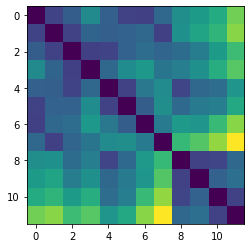

In [26]:
plt.imshow(dm)

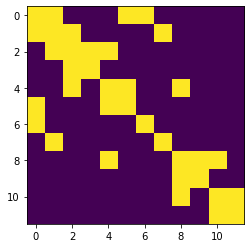

In [27]:
plt.imshow(dm < 1.8)

In [28]:
adj_mat = dm < 1.8;
for i in range(len(adj_mat)):
    adj_mat[i,i] = 0
    
#print(adj_mat)

In [29]:
edge_list = [];
for ii in range(len(adj_mat)):
    edge_list.append([])
    for jj in range(len(adj_mat)):
        if adj_mat[ii,jj]:
            edge_list[ii].append(jj)
print(edge_list)

[[1, 5, 6], [0, 2, 7], [1, 3, 4], [2], [2, 5, 8], [0, 4], [0], [1], [4, 9, 10], [8], [8, 11], [10]]


In [30]:
for i in range(len(n)):
    print(i,n[i],edge_list[i])

0  C1  [1, 5, 6]
1  C2  [0, 2, 7]
2  C3  [1, 3, 4]
3  O3  [2]
4  C4  [2, 5, 8]
5  O4  [0, 4]
6  O1  [0]
7  O2  [1]
8  C5  [4, 9, 10]
9  O5  [8]
10  C6  [8, 11]
11  O6  [10]


In [31]:



#recursive algo to get cycle of the graph
def visit(n,edge_list,visited,st):
    """
    Args:
        n - node we are searching from
        edge_list - adjacency of each node, is periodically 
            modified to remove connection to parent coming from
        st - start node
    Returns:
        arr - array of the cycle found
    """
    #print(n)
    
    if n == st and visited[st] == True:
        return [n]
    
    visited[n] = True
    r = False
    arr = []
    #print(n,edge_list[n],visited)
    
    for e in edge_list[n]:
        edge_list[e].remove(n)
        #print('\t',e)
        
        r = visit(e,edge_list,visited,st)
        #print(r)
        
        if type(r) != bool:
            arr.append(n)
            for j in r:
                arr.append(j)
                
    if arr == []:
        return False
                        
    return arr
    

visit(0,edge_list,np.zeros(len(edge_list)),0)    

[0, 1, 2, 4, 5, 0]

In [32]:
edge_list_

NameError: name 'edge_list_' is not defined

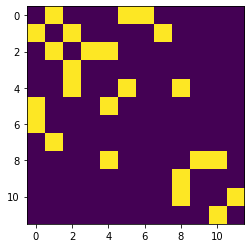

In [33]:
plt.imshow(adj_mat)

In [34]:
s = print(r)

Residue 1: ->3)-alpha-D-Fucf:reducing_end (Fuc, Z):
Base: ->3)-alpha-D-Fucf
 Properties: POLYMER CARBOHYDRATE LOWER_TERMINUS POLAR CYCLIC HEXOSE ALDOSE D_SUGAR FURANOSE ALPHA_SUGAR C6_MODIFIED DEOXY_SUGAR
 Variant types: LOWER_TERMINUS_VARIANT C6_DEOXY_SUGAR
 Main-chain atoms:  C1   C2   C3   O3 
 Backbone atoms:    C1   C2   C3   O3   C4   O4   VO4  VC1  H1   H2   H3   H4 
 Ring atoms:    C1   C2   C3   C4   O4 
 Side-chain atoms:  O1   O2   C5   O5   C6   O6   HO3  HO6  HO1  HO2  H5   HO5 1H6  2H6  3H6 
Carbohydrate Properties for this Residue:
 Basic Name: fucose
 IUPAC Name: ->3)-alpha-D-fucofuranose
 Abbreviation: ->3)-alpha-D-Fucf
 Classification: aldohexose
 Stereochemistry: D
 Ring Form: furanose
 Anomeric Form: alpha
 Modifications: 
  deoxy sugar
 Polymeric Information:
  Reducing?: yes
  Main chain connection: (_->3)
  Branch connections: none
Ring Conformer: 2T3 (twist): C-P parameters (q, phi, theta): 0.4, 0; nu angles (degrees): 54, -64, 54, -22, -22
  O1 : axial
  O2 : e

In [35]:
r.carbohydrate_info()

In [36]:
print(r.carbohydrate_info())

Carbohydrate Properties for this Residue:
 Basic Name: fucose
 IUPAC Name: ->3)-alpha-D-fucofuranose
 Abbreviation: ->3)-alpha-D-Fucf
 Classification: aldohexose
 Stereochemistry: D
 Ring Form: furanose
 Anomeric Form: alpha
 Modifications: 
  deoxy sugar
 Polymeric Information:
  Reducing?: yes
  Main chain connection: (_->3)
  Branch connections: none



In [37]:
np.array(r.xyz('C1'))

array([0., 0., 0.])

In [38]:
r.mainchain_torsion(1)

0.0

In [322]:
from scipy.spatial.transform import Rotation as Rot
import math

def rotation_matrix_from_axis(axis, theta, degrees=False):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    if degrees:
        theta *= np.pi / 180
    
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))
    a = math.cos(theta / 2.0)
    b, c, d = -axis * math.sin(theta / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

In [416]:
sc = get_score_function()
fr = pyrosetta.rosetta.protocols.relax.FastRelax()
fr.set_scorefxn(sc)
fr.max_iter(100)

In [426]:
#s = '->4)-beta-D-Fucp->4)-alpha-D-Fucp->4)-alpha-D-Manp->4)-alpha-D-ManpNAc->2)-alpha-D-Glcp'
carb = pose_from_saccharide_sequence("a-Manp6Ac-(1->3)-[b-GlcpA-(1->2)]-a-Manp6Ac-(1->3)-a-Manp6Ac-(1->3)-[b-Xylp-(1->2)]-a-Manp-(1->3)-[b-GlcpA-(1->2)]-a-Manp6Ac-(1->3)-a-Manp6Ac-(1->3)-[b-Xylp-(1->2)]-a-Manp-(1->3)-a-Manp6Ac-(1->3)")

#carb = pose_from_saccharide_sequence(s)

fr.apply(carb)

In [505]:
class mono():
    """
    Class object for a MONOMER of a carbohydrate
    
    Args:
        name (str): name of the residue
        coors (arr nx3): coordinates of heavy atoms
        atom_names (arr str): names of the atoms
        
    Variables:
        name, coor, atom_names
        atom_onehot (arr nx6 ): One-hot encoding of atoms
                    O,C,N,S,P,other
                    O first because of atom "OCN" that is O acetyl attached to C and N
        adj_mat (nxn): One-hot of bonded atoms
        edges (nx?): array of arrays of the non-sparse edge connections
        ring_atom (arr 5x1 or 6x1): defines which atoms are in the ring
        normal (arr 3x1): normal vector defined by ring atoms
        
        
    """
    def __init__(self,name,coor,atom_names,BOND_CUTOFF=1.65,ATOM_LIST=['O','C','N','S','P','X']):
        #self.is_sia = is_sia
        self.name = name
        self.coor = coor
        #print(self.coor)
        self.atom_names = atom_names
        
        self.BOND_CUTOFF = BOND_CUTOFF
        self.ATOM_LIST = ATOM_LIST
        
        #initialize empty variables
        self.atom_onehot = []
        
        self.adj_mat = []
        self.edges = []
        self.ring_atom = []
        self.ring_onehot = np.zeros(len(coor))
        self.normal = []
        self.com = []
        
        
        self.atom_name_to_oneHot()
        #print(self.coor)
        #print(atom_names,self.atom_onehot)
        self.calc_adjacency()
        #p#rint(self.coor)
        #print(self.adj_mat,self.edges)
        self.calc_ring()
        #print(self.coor)
        self.calc_adjacency() # deep copy isn't working ?Fix later? idk, probably not worth the effort. not a computational bottleneck
        #print(self.adj_mat,self.edges)
        #print(self.edges)
        #print(self.coor)
        self.normal = self.get_normal()
        #print(self.coor)
        
        self.ring_com = self.get_ring_com()
        
        #self.print_variables()
        
    def deepcopy(self):
        return copy.deepcopy(self.name), copy.deepcopy(self.coor)
        
    def print_variables(self):
        print("Name:",self.name)
        print("Coor:",self.coor)
        print("Atom_names:",self.atom_names)
        print("adjacency:",self.adj_mat,'\n',self.edges)
        print("Ring:",self.ring_atom,'\t',self.ring_onehot)
        print('Normal:',self.normal)
        print('COM:',self.ring_com)
        return
        
    def atom_name_to_oneHot(self):
        a = []
        for ii in range(len(self.atom_names)):
            a.append(np.zeros(len(self.ATOM_LIST)));
            for jj in range(len(self.ATOM_LIST)):
                if self.ATOM_LIST[jj] in self.atom_names[ii]:
                    a[ii][jj] = 1;
                    break;
                #if no atom exists in the list put it in the 'x' / other category
                if np.sum(a[ii]) == 0:
                    a[ii][-1] = 1;
        self.atom_onehot = a
        return
        
        
    def calc_adjacency(self):
        #get the adjacency matrix and edge list of the carb
        
        #calculate atom-atom distances and set cutoffs
        dm = distance_matrix(c,c)
        #print(dm)
        adj_mat = dm < self.BOND_CUTOFF;
        #no self interactions
        for i in range(len(adj_mat)):
            adj_mat[i,i] = 0
            
        #get the list of the adjacency matrix
        edge_list = [];
        for ii in range(len(adj_mat)):
            edge_list.append([])
            for jj in range(len(adj_mat)):
                if adj_mat[ii,jj]:
                    edge_list[ii].append(jj)
        
        #store local variables into class variables
        self.adj_mat = adj_mat
        self.edges = edge_list
        return
        
        
    def get_ring_com(self):
        #print(self.ring_onehot)
        ring = self.coor[self.ring_atom,:]
        self.ring_com = np.mean(ring,axis=0)
        #print(ring)
        return self.ring_com;
    
    #calculates normal vector of the ring
    #done as first ring atom, 3rd ring atom, last ring atom
    def get_normal(self):
        #print(self.ring_onehot)
        ring = self.coor[self.ring_atom]
        a1 = ring[0,:]
        a2 = ring[2,:]
        a3 = ring[-1,:]
        v1 = a1 - a2
        v2 = a2 - a3
        v1 /= np.linalg.norm(v1)
        v2 /= np.linalg.norm(v2)
        normal = np.cross(v1,v2)
        return normal / np.linalg.norm(normal)
    
    def rotate(self,anchor,R):
        """
        Args:
            anchor (arr 1x3): anchor point of the rotation
            R (3x3 rot mat): rotation matrix
        """
        new_coor = R.apply(self.coor)
        new_anc = R.apply(anchor)
        dx = anchor - new_anc
        #print(dx)
        self.coor = new_coor + dx
        
        #recalculate ring properties
        self.normal = self.get_normal()
        self.ring_com = self.get_ring_com()
        
        return
        
    #recursive algo to get cycle of the graph
    def visit(self,n,edge_list,visited,st):
        """
        Args:
            n - node we are searching from
            edge_list - adjacency of each node, is periodically 
                modified to remove connection to parent coming from
            st - start node
        Returns:
            arr - array of the cycle found
        """
        #print(edge_list)
        #print(n)

        if n == st and visited[st] == True:
            return [n]

        visited[n] = True
        r = False
        arr = []
        #print(n,edge_list[n],visited)

        for e in edge_list[n]:
            #if n in edge_list[e]:
            try:
                edge_list[e].remove(n)
            except:
                continue;
            #print('\t',e)

            r = self.visit(e,edge_list,visited,st)
            #print('\t\t',r)

            if type(r) != bool:
                arr.append(n)
                for j in r:
                    arr.append(j)

        if arr == []:
            return False

        return arr
    
    def calc_ring(self):
        #gets the ring atoms, calls recursive visit function
        ring = self.visit(0,self.edges.copy(),np.zeros(len(self.coor)),0)
        #print(ring)
        self.ring_atom  = np.unique(ring).astype(int)
        #print(self.ring_atom)
        for ii in self.ring_atom:
            self.ring_onehot[int(ii)] = 1
        self.ring_onehot = self.ring_onehot.astype(int)
        return
        
    
    
    

In [506]:

polymer = []

for ii in range(1,carb.size()+1):
    r = carb.residue(ii)
    n = []
    c = []

    #print(ii)
    
    for a in range(1,r.natoms()+1):
        name = r.atom_name(a)

        #only the real heavy atoms
        if "H" in name or "V" in name:
            continue;

        #print(a,r.atom_name(a),r.xyz(a))

        n.append(name)
        c.append(np.array(r.xyz(a)))

    c = np.array(c)
    #print(r.name(),n,c)
    #print(r)
    #print(r.name3())
    m = mono(r.name3(),c,n)
    #print(m.ring_atom)
    polymer.append(m)
    

In [507]:
polymer[0].deepcopy()

('Man',
 array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.55000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.04811928e+00,  1.44664342e+00,  0.00000000e+00],
        [ 3.47790148e+00,  1.47160036e+00,  1.64563193e-16],
        [ 1.50806246e+00,  2.11918989e+00, -1.26369295e+00],
        [-2.00414952e-02,  2.06185612e+00, -1.21358153e+00],
        [-4.75077156e-01,  6.86176098e-01, -1.15929508e+00],
        [-4.94034152e-01,  6.97554703e-01,  1.20820019e+00],
        [ 2.02400574e+00, -6.69275459e-01, -1.15921910e+00],
        [ 1.94665894e+00,  3.46907550e+00, -1.30661082e+00],
        [-6.14146416e-01,  2.71297693e+00, -2.43962436e+00],
        [-3.05325243e-01,  4.09839343e+00, -2.48025201e+00],
        [-8.84973764e-01,  4.64730001e+00, -3.64249517e+00],
        [-8.51228954e-02,  4.80375028e+00, -4.93735497e+00],
        [-2.07041047e+00,  5.00937825e+00, -3.60729354e+00]]))

In [510]:
class poly():
    
    """
    Args:
        monos (arr nx1 mono): monomers of the glycan chain
        
    Variables:
        
        adj_mat (arr nxn): adjacency matrix
        edges (arr nx?): connection edges of the shared atoms
        link_atoms (arr nxn): defines atom number of shared "linker" atoms - C or O
        
        
    """
    
    def __init__(self,monos):
        self.monos = monos;
        
        self.adj_mat = np.zeros( (len(monos),len(monos)) );
        self.link_atoms = np.zeros( (len(monos),len(monos)) );
        self.edges = []
    
        self.calc_adj()
        
        self.print_variables()
        
    #deep copy of the monomers
    def deepcopy(self):
        #to create a deep copy
        # p1 = poly( p.deepcopy() )
        return copy.deepcopy(self.monos)
        
    def print_variables(self):
        #print("Name:",self.name)
        print("adjacency:\n",self.adj_mat,'\n',self.edges)
        print("link_atoms:\n",self.link_atoms)
        return
    
    def calc_adj(self):
        #calculate adjacency between monomers
        
        #gather all coordinates of the adjacency matrix
        coor = np.zeros(3)
        res = []
        a_num = []
        for i in range(len(self.monos)):
            c = self.monos[i].coor #idc, keeping these variables public. Sue me
            for j in range(len(c)):
                res.append(i)
                a_num.append(j) # atom_number
            if len(coor) < 10:
                coor = c
            else:
                coor = np.row_stack((coor,c))
        #print(res)
        dm = distance_matrix(coor,coor)
        #adj = dm < self.monos[i].BOND_CUTOFF # SUE ME DUDE
        adj = dm < .2
        #print(adj)
        conn = np.where(adj == True)
        for i in range(len(conn[0])):
            ii = int(conn[0][i])
            jj = int(conn[1][i])
            
            r1 = res[ii]
            r2 = res[jj]
            #print('a')
            if r1 == r2:
                continue;
            #only oxygens connect
            if 'O' not in self.monos[r1].atom_names[a_num[ii]]:
                continue;
            if 'O' not in self.monos[r2].atom_names[a_num[jj]]:
                continue;
            
            self.adj_mat[r1,r2] = 1
            self.link_atoms[r1,r2] = a_num[ii]
            self.link_atoms[r2,r1] = a_num[jj]
            #print(a[ii],a[jj],r1,r2)
            
            
        for ii in range(len(self.adj_mat)):
            self.edges.append([])
            for jj in range(len(self.adj_mat[ii])):
                if self.adj_mat[ii,jj]:
                    self.edges[ii].append(jj)
        
        self.link_atoms = self.link_atoms.astype(int)
        return;
    
    #gets com of rings (1x3)
    def get_com(self):
        com = 0
        for i in self.monos:
            com += i.ring_com;
        return com / len(self.monos)
    
    #returns all rings com's (nx3)
    def get_ring_coms(self):
        com = []
        for i in self.monos:
            com.append(i.ring_com);
        return np.array(com)
    
    #gets atomic coordinates - used for alignment and atom losses (n_atoms x 3)
    def get_atom_coor(self):
        coor = np.zeros(3)
        for i in range(len(self.monos)):
            c = self.monos[i].coor #idc, keeping these variables public. Sue me
            if len(coor) < 4:
                coor = c
            else:
                coor = np.row_stack((coor,c))
        return coor
    
        
    #recursively find all connections in the polymer chain
    # rotates:  R1 -> O ''->'' R2
    # anchor: O
    def find_all_connections(self,r1,r2,arr=[]):
        #print(r1,r2)
        #arr = []
        arr.append(r2)
        #print(r2,self.edges[r2])
        for e in self.edges[r2]:
            
            if e != r1 and e not in arr:
                #print('\t',r1,r2,e,'\t',arr)
                arr.append(e)
                a = self.find_all_connections(r2,e,arr)
                for kk in a:
                    if kk not in arr:
                        arr.append(kk)
            #else:
                #print('banned:\t',r1,'\t',r2)
        return np.unique(arr).astype(int)
    
    #translate the entire carbohydrate
    def translation(self,dx):
        for m in self.monos:
            m.coor += dx
        return
    
    #rotate the entire carbohydrate
    def euler_rotation(self,R):
        for m in self.monos:
            m.coor = R.apply(m.coor)
        return
        
    
    #rotate a monomer and all lever arm residues in the chain by some change in phi
    def dihedral_rotation(self,r1,r2,d_phi,degrees=True):
        #find the lever arm to rotate
        monos_to_rot = self.find_all_connections(r1,r2,arr=[])
        anchor1 = self.monos[r1].coor[self.link_atoms[r1,r2],:]
        anchor2 = self.monos[r2].coor[self.link_atoms[r2,r1],:]
        #print(r1,r2,'\tmono_to_rot: ',monos_to_rot)
        
        #determine which is the oxygen and get the connection needed
        a1_name = self.monos[r1].atom_names[self.link_atoms[r1,r2]]
        a2_name = self.monos[r2].atom_names[self.link_atoms[r2,r1]]
        anchor = []
        
        #print('r1 atom:',a1_name,'r2 atom:',a2_name)
        
        #same position!!!
        #print(anchor1,anchor2)
        #print( self.monos[r1].coor[ self.link_atoms[r1,r2],: ], self.monos[r2].coor[ self.link_atoms[r2,r1],: ] )
        
        #same atom, different name!
        #a1_name = self.monos[r1].atom_names[self.link_atoms[r2,r1]]
        #a2_name = self.monos[r2].atom_names[self.link_atoms[r1,r2]]
        #print(a1_name,a2_name)
        
        vec = []
        
        #if 'O' in a1_name:
            #print(r1)
            #print(self.monos[r1].edges[self.link_atoms[r1,r2]])
        #print( self.monos[r1].atom_names[ self.monos[r1].edges[self.link_atoms[r1,r2]][0] ])
        conn = self.monos[r1].coor[ self.monos[r1].edges[self.link_atoms[r1,r2]][0] ,:]
        vec = anchor1 - conn
        #print(conn,vec)
        anchor = anchor1
        
        #print(self.monos[r1].edges[self.link_atoms[r1,r2]])
            
        #elif 'O' in a2_name:
        #    conn = self.monos[r2].coor[ self.monos[r2].edges[self.link_atoms[r2,r1]][0] ,:]
        #    vec = anchor2 - conn
        #    anchor = anchor2
            
        #else:
        #    print('OOF i fucked up')
            
        #get the rotation matrix
        R = rotation_matrix_from_axis(vec, d_phi,degrees=degrees)
        #print(R)
        R = Rot.from_matrix(R)
        #print(R)
        
        #rotate all monomers in the lever arm
        for m in monos_to_rot:
            self.monos[m].rotate(anchor,R);
            
    def output_pdb(self):
              
        '''
        
        # 
        #  1 -  6        Record name     "ATOM  "  
        #  7 - 11        Integer         Atom serial number.  
        # 13 - 16        Atom            Atom name.   
        # 17             Character       Alternate location indicator.
        # 18 - 20        Residue name    Residue name.  
        # 22             Character       Chain identifier.   
        # 23 - 26        Integer         Residue sequence number. 
        # 27             AChar           Code for insertion of residues.  
        # 31 - 38        Real(8.3)       Orthogonal coordinates for X in Angstroms. 
        # 39 - 46        Real(8.3)       Orthogonal coordinates for Y in Angstroms. 
        # 47 - 54        Real(8.3)       Orthogonal coordinates for Z in Angstroms.  	
        
        '''                   
        anum = 1;
        resnum = 1;
        out = ""
        
        for m in self.monos:
            
            for a in range(len(m.coor)):
                out += "ATOM  "
                out += str(anum).rjust(5) + ' '
                out += m.atom_names[a].rjust(4)
                out += ' ' # no alt location indicator
                out += m.name.ljust(4)
                out += 'A'
                out += str(resnum).rjust(4)
                out += '   '
                #print(m.coor[a,:])
                c = str( round(m.coor[a,0],3) )
                while len( c.split('.')[1] ) < 3:
                    c += '0'
                out += c.rjust(8)
                c = str( round(m.coor[a,1],3) )
                while len( c.split('.')[1] ) < 3:
                    c += '0'
                out += c.rjust(8)
                c = str( round(m.coor[a,2],3) )
                while len( c.split('.')[1] ) < 3:
                    c += '0'
                out += c.rjust(8)
                
                
                #out += str( round(m.coor[a,1],3) ).rjust(8)
                #out += str( round(m.coor[a,2],3) ).rjust(8)
                
                out += '\n'
                anum += 1
            resnum += 1
                
        return out
        

polymer = []

for ii in range(1,carb.size()+1):
    r = carb.residue(ii)
    n = []
    c = []

    #print(ii)
    
    for a in range(1,r.natoms()+1):
        name = r.atom_name(a)

        #only the real heavy atoms
        if "H" in name or "V" in name:
            continue;

        #print(a,r.atom_name(a),r.xyz(a))

        n.append(name)
        c.append(np.array(r.xyz(a)))

    c = np.array(c)
    #print(r.name(),n,c)
    #print(r)
    #print(r.name3())
    m = mono(r.name3(),c,n)
    #print(m.ring_atom)
    polymer.append(m)
    
p = poly(polymer)
print(len(polymer))


adjacency:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] 
 [[1], [0, 2, 8], [1, 3], [2, 4, 9], [3, 5, 10], [4, 6], [5, 7, 11], [6], [1], [3], [4], [6]]
link_atoms:
 [[0 3 0 0 0 0 0 0 0 0 0 0]
 [7 0 3 0 0 0 0 0 8 0 0 0]
 [0 7 0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 3 0 0 0 0 8 0 0]
 [0 0 0 7 0 3 0 0 0 0 8 0]
 [0 0 0 0 7 0 3 0 0 0 0 0]
 [0 0 0 0 0 7 0 3 0 0 0 8]
 [0 0 0 0 0 0 7 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 7 0 0 0 0 0]]
12


In [512]:
p1 = poly( p.deepcopy() )

adjacency:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] 
 [[1], [0, 2, 8], [1, 3], [2, 4, 9], [3, 5, 10], [4, 6], [5, 7, 11], [6], [1], [3], [4], [6]]
link_atoms:
 [[0 3 0 0 0 0 0 0 0 0 0 0]
 [7 0 3 0 0 0 0 0 8 0 0 0]
 [0 7 0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 3 0 0 0 0 8 0 0]
 [0 0 0 7 0 3 0 0 0 0 8 0]
 [0 0 0 0 7 0 3 0 0 0 0 0]
 [0 0 0 0 0 7 0 3 0 0 0 8]
 [0 0 0 0 0 0 7 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 7 0 0 0 0 0]]


In [425]:
out = ""
for jj in range(200):
    
    
    #find edge and then perturb
    r = np.random.randint(len(p.monos))
    edges = p.edges[r]
    a = np.random.randint(len(edges) )
    #print(len(edges),a)
    e = edges[ a ]
    
    #print('\t\t',r,e)
    p.dihedral_rotation(r,e,np.random.normal(0,5),degrees=True)
    
    #center the darn thing
    com = p.get_com()
    #print(com)
    p.translation(0 - com)
    
    #align with x axis
    vec = np.array((1,0,0))
    orient = p.monos[0].get_ring_com() - p.monos[-1].get_ring_com()
    #print(orient, vec)
    #cant cacluate if same vector
    if np.dot(vec,orient) != np.linalg.norm(orient):
        
        R = rotation_matrix_from_vectors(orient,vec)
        R = Rot.from_matrix(R)
        p.euler_rotation(R)
    
    out += "MODEL    " + str(jj) + '\n'
    out += p.output_pdb()
    out += 'TER\nENDMDL\n'
    
f = open('./test_pdbs/traj.pdb','w+')
f.write(out)
f.close()

In [285]:
out = p.output_pdb()
#print(out)
f = open('./test_pdbs/1.pdb','w+')
f.write(out)
f.close()

In [286]:
p.rotation(0,1,15,degrees=True)
out = p.output_pdb()
#print(out)
f = open('./test_pdbs/2.pdb','w+')
f.write(out)
f.close()

mono_to_rot:  [1, 2, 3, 4]
r1 atom:  O2  r2 atom:  O1 
 C2 
[1.55 0.   0.  ] [0.47400574 1.33855092 0.        ]
[1]


In [287]:
p.rotation(3,4,15,degrees=True)

mono_to_rot:  [4]
r1 atom:  O4  r2 atom:  O1 
 C4 
[-8.85174044 -1.32283891  0.5476691 ] [-0.52256566  0.96572485  0.90038917]
[3]


In [288]:
p.rotation(0,1,15)
out = p.output_pdb()
#print(out)
f = open('./test_pdbs/3.pdb','w+')
f.write(out)
f.close()

mono_to_rot:  [1, 2, 3, 4]
r1 atom:  O2  r2 atom:  O1 
 C2 
[1.55 0.   0.  ] [0.47400574 1.33855092 0.        ]
[1]


In [ ]:
for jj in range(200):
    
    
    #find edge and then perturb
    r = np.random.randint(len(p.monos))
    edges = p.edges[r]
    a = np.random.randint(len(edges) )
    #print(len(edges),a)
    e = edges[ a ]
    
    #print('\t\t',r,e)
    p.dihedral_rotation(r,e,np.random.normal(0,5),degrees=True)

In [486]:
polymer = []

for ii in range(1,carb.size()+1):
    r = carb.residue(ii)
    n = []
    c = []

    #print(ii)
    
    for a in range(1,r.natoms()+1):
        name = r.atom_name(a)

        #only the real heavy atoms
        if "H" in name or "V" in name:
            continue;

        #print(a,r.atom_name(a),r.xyz(a))

        n.append(name)
        c.append(np.array(r.xyz(a)))

    c = np.array(c)
    #print(r.name(),n,c)
    #print(r)
    #print(r.name3())
    m = mono(r.name3(),c,n)
    #print(m.ring_atom)
    polymer.append(m)
    
p2 = poly(polymer)
#print(len(polymer))

adjacency:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] 
 [[1], [0, 2, 8], [1, 3], [2, 4, 9], [3, 5, 10], [4, 6], [5, 7, 11], [6], [1], [3], [4], [6]]
link_atoms:
 [[0 3 0 0 0 0 0 0 0 0 0 0]
 [7 0 3 0 0 0 0 0 8 0 0 0]
 [0 7 0 3 0 0 0 0 0 0 0 0]
 [0 0 7 0 3 0 0 0 0 8 0 0]
 [0 0 0 7 0 3 0 0 0 0 8 0]
 [0 0 0 0 7 0 3 0 0 0 0 0]
 [0 0 0 0 0 7 0 3 0 0 0 8]
 [0 0 0 0 0 0 7 0 0 0 0 0]
 [0 7 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0 0 0]
 [0 0 0 0 7 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 7 0 0 0 0 0]]


In [513]:
p.get_ring_coms()

array([[ 7.68510514e-01,  1.05231092e+00, -6.06094926e-01],
       [ 5.00728030e+00,  1.76144406e+00,  1.63044246e+00],
       [ 9.12790802e+00,  1.19860387e+00, -9.36125663e-01],
       [ 1.31100226e+01,  3.02193748e+00,  1.14301086e+00],
       [ 1.74970580e+01,  1.44174829e+00, -3.58515860e-01],
       [ 2.14660947e+01,  4.07611287e+00,  8.83069693e-01],
       [ 2.58277129e+01,  2.58909437e+00, -6.97772938e-01],
       [ 2.94192041e+01,  2.07437885e+00,  2.59054305e+00],
       [ 5.84964250e+00,  5.93864549e+00, -1.72105266e-01],
       [ 1.34097455e+01,  6.29214999e+00, -2.04005592e+00],
       [ 1.87774753e+01, -1.82079661e-02,  3.85936162e+00],
       [ 2.43896177e+01, -1.59981748e+00,  4.06533277e-01]])

In [515]:
p1.get_ring_coms()

array([[ 7.68510514e-01,  1.05231092e+00, -6.06094926e-01],
       [ 5.00728030e+00,  1.76144406e+00,  1.63044246e+00],
       [ 9.12790802e+00,  1.19860387e+00, -9.36125663e-01],
       [ 1.31100226e+01,  3.02193748e+00,  1.14301086e+00],
       [ 1.74970580e+01,  1.44174829e+00, -3.58515860e-01],
       [ 2.14660947e+01,  4.07611287e+00,  8.83069693e-01],
       [ 2.58277129e+01,  2.58909437e+00, -6.97772938e-01],
       [ 2.94192041e+01,  2.07437885e+00,  2.59054305e+00],
       [ 5.84964250e+00,  5.93864549e+00, -1.72105266e-01],
       [ 1.34097455e+01,  6.29214999e+00, -2.04005592e+00],
       [ 1.87774753e+01, -1.82079661e-02,  3.85936162e+00],
       [ 2.43896177e+01, -1.59981748e+00,  4.06533277e-01]])

In [489]:
for jj in range(200):
    
    
    #find edge and then perturb
    r = np.random.randint(len(p.monos))
    edges = p.edges[r]
    a = np.random.randint(len(edges) )
    #print(len(edges),a)
    e = edges[ a ]
    
    #print('\t\t',r,e)
    p.dihedral_rotation(r,e,np.random.normal(0,5),degrees=True)

In [490]:
p.get_ring_coms()

array([[-58.23659884,  45.55760607, -17.62667392],
       [-60.42924363,  46.09103156, -21.66488294],
       [-60.54042754,  50.9656886 , -22.61891529],
       [-60.91558772,  53.55434539, -26.36183188],
       [-62.75808771,  53.42586603, -30.64492391],
       [-62.49449301,  49.22549136, -32.57324287],
       [-65.1712542 ,  45.0386297 , -32.28404208],
       [-63.10186532,  43.81532675, -30.99952757],
       [-55.86728691,  46.5230527 , -21.38485702],
       [-63.07940603,  56.01015242, -27.62190059],
       [-65.01115364,  54.17823181, -32.42705155],
       [-62.0377076 ,  44.44501393, -28.88528542]])

In [491]:
p2.get_ring_coms()

array([[ 7.68510514e-01,  1.05231092e+00, -6.06094926e-01],
       [ 5.00728030e+00,  1.76144406e+00,  1.63044246e+00],
       [ 9.12790802e+00,  1.19860387e+00, -9.36125663e-01],
       [ 1.31100226e+01,  3.02193748e+00,  1.14301086e+00],
       [ 1.74970580e+01,  1.44174829e+00, -3.58515860e-01],
       [ 2.14660947e+01,  4.07611287e+00,  8.83069693e-01],
       [ 2.58277129e+01,  2.58909437e+00, -6.97772938e-01],
       [ 2.94192041e+01,  2.07437885e+00,  2.59054305e+00],
       [ 5.84964250e+00,  5.93864549e+00, -1.72105266e-01],
       [ 1.34097455e+01,  6.29214999e+00, -2.04005592e+00],
       [ 1.87774753e+01, -1.82079661e-02,  3.85936162e+00],
       [ 2.43896177e+01, -1.59981748e+00,  4.06533277e-01]])

In [541]:
def align(a,b):
    '''
    Aligns polymer A to polymer B
    e.g. A is translated and rotated
    Taken from AF3 paper
    
        Args:
            a (polymer)
            b (polymer)
        Return:
            null / updated B
    '''
    com_a = a.get_com()
    com_b = b.get_com()
    dx = com_b - com_a;
    
    print(com_a,com_b,dx)
    a.translation(dx)
    
    com_a = a.get_com()
    com_b = b.get_com()
    print(com_a,com_b,dx)
    
    a_coor = a.get_atom_coor()
    b_coor = b.get_atom_coor()
    
    a_sum = np.sum(a_coor,axis=0)
    b_sum = np.sum(b_coor,axis=0)
    
    #print(a_coor,b_coor)
    #print(a.get_ring_coms(),b.get_ring_coms())
    
    U, S, V = np.linalg.svd(np.outer(a_sum,b_sum),full_matrices=True)
    print(np.shape(U),np.shape(V),np.shape(S))
    R = np.matmul(U,V)
    
    #remove reflection
    if np.linalg.det(R) < 0:
        F = np.eye(3)
        F[2,2] = -1
        R1 = np.matmul(U,F)
        R = np.matmul(R1,V)
    
    print(R)
    R = Rot.from_matrix(R)
    a.euler_rotation(R)
    return;
    
def atom_rmsd(a,b):
    '''
    Calculates RMSD on atom-atom basis
    
        Args:
            a (polymer)
            b (polymer)
        Return:
            rmsd (float)
    '''
    
    a_coor = a.get_atom_coor()
    b_coor = b.get_atom_coor()
    
    dx = a_coor - b_coor;
    print(dx[:10,:])
    
    dx = np.linalg.norm(dx,axis=0);
    
    rmsd = np.sqrt( np.sum( dx**2 ) / len(dx) )
    return rmsd
    
def ring_rmsd(a,b):
    '''
    Calculates RMSD on ring-ring basis
    
        Args:
            a (polymer)
            b (polymer)
        Return:
            rmsd (float)
    '''
    
    a_coor = a.get_ring_coms()
    b_coor = b.get_ring_coms()
    
    dx = a_coor - b_coor;
    dx = np.linalg.norm(dx,axis=0);
    rmsd = np.sqrt( np.sum( dx**2 ) / len(dx) )
    return rmsd
    

In [556]:
align(p,p1)

[15.38752267  2.3190334   0.47519087] [15.38752267  2.3190334   0.47519087] [0. 0. 0.]
[15.38752267  2.3190334   0.47519087] [15.38752267  2.3190334   0.47519087] [0. 0. 0.]
(3, 3) (3, 3) (3,)
[[ 0.99949018  0.00777492 -0.03096674]
 [-0.00163251  0.98107327  0.19362999]
 [ 0.0318861  -0.19348072  0.98058579]]


In [557]:
p.translation(5)
align(p,p1)

[15.38752267  2.3190334   0.47519087] [15.38752267  2.3190334   0.47519087] [0. 0. 0.]
[15.38752267  2.3190334   0.47519087] [15.38752267  2.3190334   0.47519087] [0. 0. 0.]
(3, 3) (3, 3) (3,)
[[ 0.84268682  0.52401126 -0.12365724]
 [ 0.38762804 -0.43108255  0.81480816]
 [ 0.37366217 -0.73456111 -0.56638905]]


In [548]:
atom_rmsd(p,p1)

[[ 0.          0.          0.        ]
 [-0.07830554  0.4858481  -0.02381296]
 [ 0.32360184 -2.07118905  0.52196885]
 [ 0.25873735 -1.66982989  0.50955046]
 [ 0.41489323 -3.03707562  3.21865209]
 [ 0.48050184 -3.42696083  3.12379038]
 [ 0.103147   -1.0094757   2.50005842]
 [ 0.35951829 -1.9074591  -2.04988709]
 [-0.42324877  2.31597777  1.94297059]
 [ 0.786674   -5.41551738  3.8108977 ]]


61.44490446195425

In [535]:
ring_rmsd(p,p1)

0.0

In [19]:


out_fasta = "";
bad = [];

print("Hello")

for ii in range(len(ls)):
    has_carb = True;

    f = '../preprocess/capsif_pdb/' + ls[ii]
    #only run for single pdb
        
    try:
        #signal.signal(signal.SIGALRM, timeout_handler)
        #signal.alarm(1)
        pose = [];
        
        #try:
        pose = get_pose(f)
        #except:
        #    print("Pose took over a minute to load")
        #    continue;
        
        chains = get_chain_seq(pose)
        
        #First and foresmost - find the carbohydrate
        
        carb_res = get_carb_res(pose);
        if (len(carb_res) == 0):
            #print("Carb not detected")
            has_carb = False;
        #break;

        ag_coor, ag_label = get_carbXYZ(pose,carb_res)
        
        print(ii,len(ls),ls[ii],has_carb)
        
        #go thru all protein chains
        nc = pose.num_chains();
        for c in range(1,nc+1):
            
            #only protein chains allowed
            if pose.residue(pose.chain_begin(c)).is_protein() == False:
                continue;
            
            coor, label = get_protchainXYZ(pose,c)
            cb, ca, frame = get_chain_coor(pose,c)
            
            #ßprint(len(ag_coor))
            #get interacting residues
            res = get_interact_residues(pose,coor,label,ag_coor,ag_label,carb_res)
            res = np.array(res) # for readability
            #print(res)

            seq = pose.chain_sequence(c)
            out_fasta += ">" + ls[ii][:4] + "_" + str(c) + "\n"
            out_fasta += seq + "\n"

            #get the label, recall in pose numbering
            new_label = np.zeros(( pose.chain_end(c) - pose.chain_begin(c) + 1 , len(carb_dict) + 1 ) )
            for r in range(pose.chain_begin(c), pose.chain_end(c) ):
                #if no protein binds it
                if (len(res) == 0):
                    out_fasta += "x,"
                    continue;

                if r in res[:,0]:
                    new_label[r-pose.chain_begin(c),0] = 1;
                    
                    ind = np.where(res[:,0] == r)[0]
                    #print(ind)
                    out_fasta += str(res[ind[0],1])
                    new_label[r-pose.chain_begin(c),res[ind[0],1]+1] = 1
                    for kk in range(1,len(ind)):
                        out_fasta += "|" + str(res[kk,1])
                        new_label[r-pose.chain_begin(c),res[kk,1]+1] = 1
                else:
                    out_fasta += "x"
                out_fasta += ","
            out_fasta += "\n"

            #os.path.abspath(file_seq)
            f_seq = open(out_file,'w+')
            f_seq.write(out_fasta)
            f_seq.close()
            #print(a_seq,'\n',b_seq,'\n',ag_seq)
            
            np.savez('../preprocess/capsif_coor/' + ls[ii][:4] + "_" + str(c) + ".npz",ca=ca,cb=cb,frame=frame,label=new_label)

    except:
        bad.append(ls[ii])
    #break;
    
    


Hello
0 808 3R4Z_1.pdb True
1 808 5A6M_1.pdb True
2 808 5GOQ_1.pdb True
3 808 4RK0_1.pdb True
4 808 6ROE_1.pdb True
5 808 3PUN_1.pdb True
6 808 1X9D_1.pdb True
7 808 4WZT_1.pdb True
8 808 3KZH_1.pdb True
9 808 2WMG_1.pdb True
10 808 1SZ2_1.pdb True
11 808 4XFE_1.pdb True
12 808 4XR8_2.pdb True
13 808 2E9M_1.pdb True
14 808 1A3K_1.pdb True
15 808 2DTX_1.pdb True
16 808 4QQQ_1.pdb True
17 808 3RSJ_1.pdb True
18 808 4LO2_1.pdb True
19 808 3VV1_1.pdb True
20 808 6UAS_1.pdb True
21 808 2CGY_1.pdb True
22 808 1K1W_1.pdb True
23 808 2J44_1.pdb True
24 808 3QSP_1.pdb True
25 808 4NFD_1.pdb True
26 808 4UA8_1.pdb True
27 808 5U3E_1.pdb True
28 808 1SL6_1.pdb True
29 808 6R2J_1.pdb True
30 808 4TF4_1.pdb True
31 808 4YFZ_1.pdb True
32 808 5MQS_1.pdb True
33 808 4XRE_1.pdb True
34 808 1RYD_1.pdb True
35 808 4B8S_1.pdb True
36 808 5KGA_1.pdb True
37 808 5GTG_1.pdb True
38 808 3M3Q_1.pdb True
39 808 3OO6_1.pdb True
40 808 5DEQ_1.pdb True
41 808 3SEJ_1.pdb True
42 808 4YW2_1.pdb True
43 808 6ER3_1.p

In [20]:
print(bad)
print(out_fasta)

['3OSQ_1.pdb', '3OSR_1.pdb']
>3R4Z_1
KLSKASLRAIERGYDEKGPEWLFEFDITPLKGDLAYEEGVIRRDPSAVLKVDDEYHVWYTKGEGETVGFGSDNPEDKVFPWDKTEVWHATSKDKITWKEIGPAIQRGAAGAYDDRAVFTPEVLRHNGTYYLVYQTVKAPYLNRSLEHIAIAYSDSPFGPWTKSDAPILSPENDGVWDTDEDNRFLVKEKGSFDSHKVHDPCLMFFNNRFYLYYKGETMGESMNMGGREIKHGVAIADSPLGPYTKSEYNPITNSGHEVAVWPYKGGMATMLTTDGPEKNTCQWAEDGINFDIMSHIKGAPEAVGFFRPDDPISGIEWGLSHKYDASWNWNYLCFFKTRRQVLDAGSYQQTGDSGAVHH
x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,4,x,4,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,4,x,4,x,x,x,x,x,x,x,x,x,x,4,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,4,4,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,

In [65]:
type(carb_res)

NoneType

In [66]:
type(carb_res) == type(None)

True

In [48]:
pose.num_chains()

2

In [50]:
pose.chain_begin(1)
pose.residue(1).is_protein()

True

In [27]:
#print(a_coor)
a_label
carb_res

[[871, -1, 10], [872, -1, 10], [873, -1, 10]]

In [37]:
print(np.shape(a_coor))

(1643, 3)


In [70]:
#res = np.array(res)